This version of the snake game allows you to implement and run your evolutionary algorithm

# EVAC Exam Part 1

#### For this part of the exam, 2 solutions were implemented and compared, Snake and SimpleSnake (with Snake being the definitive answer for this section of the examination). The code and charts for both can be found below, with a text explanation above each code tile altered/added.

### *Note: My definitive answer to this question is Snake. SimpleSnake is merely a benchmark used for comparison and improvement of Snake, in line with article 4 of the marking criteria.*

### *Note: The training loop outputs have been deleted in the .pdf version of this notebook for ease of reading. In every other regard, the .ipynb and .pdf files are identical.*

#### Finally, at the end of the notebook, the training graphs and final thoughts are provided, along with a function to load and run the best agents from both versions.

In [1]:
import random
import time
import turtle

#!pip install deap
from deap import base
from deap import creator
from deap import tools
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [3]:
HEADLESS = True

In [4]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green",'black','red','blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

# Changes made to class snake

#### In order to enable the snake, not only to be able to sense whether or not it is getting closer to the food (see: `self.moveAI()`), but also be more aware of it's surroundings, the snake can now "see" in 8 directions (see: `self.sensors()`), and calculates the Euclidean distance to the tile blocking its vision in each direction. A blocking tile in this case can be food, walls, or its tail.
#### Note: *The snake does not differentiate between walls and its tail, as both are to be avoided all the same.*

#### Furthermore, a list of available moves have been added for the AI to choose from, in `self.legal_moves`

#### SimpleSnake on the other hand can only sense in 4 directions, with a range of only 1 tile. E.g., if SimpleSnake's head is at [1,1] it can sense the presence of food/obstacles at [0,1], [1,0], [2,1], and [1,2] only. Therefore, it also uses a simpler but faster AI.

In [5]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.legal_moves = ["left", "right", "up", "down"]
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def getAheadLocation(self):
        self.ahead = [ self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)] 
        
    def sense_wall_ahead(self):
        self.getAheadLocation()
        return( self.ahead[0] == 0 or self.ahead[0] == (YSIZE-1) or self.ahead[1] == 0 or self.ahead[1] == (XSIZE-1) )
        
    def sense_food_ahead(self):
        self.getAheadLocation()
        return self.food == self.ahead

    def sense_tail_ahead(self):
        self.getAheadLocation()
        return self.ahead in self.snake
    
    def euclid(self, coord):
        # simply calculates the Euclidean distance between a given point and the head of the snake
        return math.sqrt(math.pow((self.snake[0][0]-coord[0]),2) + math.pow((self.snake[0][1]-coord[1]),2))
    
    def readings(self, directions):
        # returns a 2 element list with the inverse of Euclidean distances for each sensor
        # e.g., if food is detected 4 tiles away => return [1/4, 0]
        # e.g., if wall or tail is detected 6 tiles away => return [0, 1/6]
        focus = copy.deepcopy(self.snake[0])
        while (focus[0] >= 0 and focus[1] >= 0) and (focus[0] < self.XSIZE and focus[1] < self.YSIZE):
            focus[0] += directions[0]
            focus[1] += directions[1]
            if focus == self.food:
              return [0, 1/self.euclid(focus)]
            elif focus in self.snake[1:]:
              return [1/self.euclid(focus), 0]
        return [1/self.euclid(focus), 0]
    
    def readings_old(self, directions):
        # simpler version of self.readings() that can see only 1 tile ahead in any direction
        # returns -1 if wall or tail ahead, returns 1 if food ahead, else returns 0
        focus = copy.deepcopy(self.snake[0])
        focus[0] += directions[0]
        focus[1] += directions[1]
        if (focus in self.snake[1:]) or (focus[0] < 0 or focus[1] < 0) or (focus[0] >= self.XSIZE or focus[1] >= self.YSIZE):
            return -1
        elif focus == self.food:
            return 1
        else:
            return 0

    def sensors(self, simpleSnake=False):
        # [+1,+1] to go SE, [-1,-1] to go NW, [+1,-1] to go SW, [-1,+1] to go NE
        # [+1, 0] to go  S, [-1, 0] to go  N, [ 0,+1] to go  E, [ 0,-1] to go  W
        eyes = []
        if not simpleSnake:
            # returns a 2n elements list of readings for sensors in n different directions
            # for 8 sensors, returns list of length 16
            directions = [[1,0], [1,-1], [0,-1], [-1,-1], [-1,0], [-1,1], [0,1], [1,1]]
            # directions = [ S, SW, W, NW, N, NE, E, SE ]
            for i in directions:
                eyes += self.readings(i)
        else:
            # returns a n elements list of readings for sensors in n different directions
            # for 4 sensors, returns list of length 4
            directions = [[1,0], [0,-1], [-1, 0], [0,1]]
            # directions = [ S, W, N, E ]
            for i in directions:
              eyes.append(self.readings_old(i))
        return eyes
    
    def move_AI(self, AIbrain, simpleSnake=False):
        # Snake feed forward inputs : [ S, SW, W, NW, N, NE, E, SE, euclid(food) ]
        # Snake len(inputs) = (8*2)+1 = 17

        # SimpleSnake feed forward inputs : [ S, W, N, E, euclid(food) ]
        # SimpleSnake len(inputs) = 4+1 = 5
      
        inputs = self.sensors(simpleSnake)
        inputs.append(1/self.euclid(self.food))
        output = AIbrain.feedForward(inputs)
        decision = np.argmax(output, axis=0)
        if decision < 4 and decision >= 0:
            self.snake_direction = self.legal_moves[decision]
        else:
            raise ValueError("check no. of out channels in brain.")

# The AI

#### Given the level of complexity of the problem, a simple Multi-Layer Perceptron was opted for. The MLP code from EVCO Workshop 6B was used as the foundation, with the only major alteration being the addition of another hidden layer (labeled h3 in the code below).

#### ReLU activation was used at each layer for simplicity of calculation.

#### Sigmoid activation was considered for the final activation, however probabilities produced by a sigmoid are independent of eachother, making softmax the clear choice as the final activation function. This was in order to have the 4 outputs sum to 1, which is necessary since the snake can only pick 1 direction, and therefore will have to produce a clear choice each time.

#### `MLP` is the definitive AI used in the training for Snake below.
#### `MLP_old` is a stripped back version of `MLP`, with no hidden layers. This is the AI used in the training for SimpleSnake below.
#### Both are identical in every other way, except for the number of hidden layers.

In [6]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numHidden3, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numHidden3 = numHidden3
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_h3 = np.random.randn(self.numHidden3, self.numHidden2)
        self.w_h3_o = np.random.randn(self.numOutput, self.numHidden3)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)

        h1 = np.dot(self.w_i_h1, inputsBias)          # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]               # Activate hidden layer 1

        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]               # Activate hidden layer 2

        h3 = np.dot(self.w_h2_h3, h2)                 # feed layer 2 to hidden layer 3
        h3 = [self.ReLU(x) for x in h3]               # Activate hidden layer 3

        output = np.dot(self.w_h3_o, h3)              # feed to output layer
        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_h3 = list(self.w_h2_h3.flatten())
        flat_w_h3_o = list(self.w_h3_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_h3 + flat_w_h3_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_H3 = self.numHidden3 * self.numHidden2
        numWeights_H3_O = self.numOutput * self.numHidden3

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_h3 = np.array(Wgenome[(numWeights_I_H1+numWeights_H1_H2):(numWeights_H1_H2+numWeights_I_H1+numWeights_H2_H3)])
        self.w_h2_h3 = self.w_h2_h3.reshape((self.numHidden3, self.numHidden2))

        self.w_h3_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1+numWeights_H2_H3):])
        self.w_h3_o = self.w_h3_o.reshape((self.numOutput, self.numHidden3))


class MLP_old(object):
    def __init__(self, numInput, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1
        self.numOutput = numOutput
        self.w_i_o = np.random.randn(self.numOutput, self.numInput)
        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)
        output = np.dot(self.w_i_o, inputsBias)
        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_o = list(self.w_i_o.flatten())
        return( flat_w_i_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_O = self.numOutput * self.numInput
        self.w_i_o = np.array(Wgenome[:])
        self.w_i_o = self.w_i_o.reshape((self.numOutput, self.numInput))

In [7]:
snake_game = snake(XSIZE,YSIZE)

In [8]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

# Changes made to run_game()

#### The function now takes in the parameter `brain`, which is essentially the MLP AI brain implemented above. This brain is then used to call the method `snake_game.move_AI(brain, simpleSnake=False)`, which will change the direction of the snake according to the AI.
#### The parameter `simpleSnake=False` is used to determine which functions to call within the snake class, depending on the variant of snake.

#### Two more variables have been added, `timer` and `age`.
#### `age` is incremented at every iteration and contributes to the fitness, encouraging survival (by consuming food, and not hitting walls or turning into itself).
#### `timer` is decremented at every iteration, and is reset when food is consumed. If `timer` reaches 0, the snake dies of starvation. The intuition is that this acts as a counter-weight against `age`, discouraging the snake from eternally going in circles to increase `age`.

#### The function now returns a fitness value (a combination of `score` and `age`). If `age` < 256, fitness = `score + (age/256)`. Otherwise, fitness = `score`. This allows the agents to initially increase their fitness by both consuming food and prolonging death. Once the latter has been mastered, the agents will need to consume more food to increase their fitness.

#### `age` contributes to fitness up to 256, after which it makes no difference.
#### `timer` starts at 256, and is reset to 256 when food is consumed.
#### The number 256 was chosen considering the fact that the world is 16x16=256 tiles, and so the snake can afford to explore all 256 tiles before dying of starvation, therefore encouraging exploration but discouraging repetitive movement. 100 was also used in testing, but this proved to be too short a time frame in the later generations when agents were too big to simply move across the world to the next apple.

#### The algorithm was not implemented as a multi-objective problem, since `age` is only used in the initial stage of the evolution, after which the fitness relies entirely on `score`.

In [9]:
def run_game(display,snake_game, headless, brain, simpleSnake=False):

    score = 0
    timer = 256
    age = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    flag = True
    while not game_over:

        # ****YOUR AI BELOW HERE******************

        snake_game.move_AI(brain, simpleSnake)
        
        # ****YOUR AI ABOVE HERE******************

        snake_game.update_snake_position()

        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            timer = 256
            if not headless: display.add_snake_segment()
        elif timer > 0:
            timer -= 1
        else:
            game_over = True
            print("Snake died of starvation")

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True
            print("Snake turned into itself!")

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
            print("Snake hit a wall!")
        
        if not game_over:
            age += 1

        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.

    print("\nFINAL score - " + str(score))
    if not headless: turtle.done()

    if age < 256:
        return score + (age/256)
    else:
        return score


# MLP & toolbox initialisation (for Snake)

#### The number of channels for the hidden layers (16, 12, 8) were chosen due to the complexity of the data being fed to the snake, primarily from the 8 sensors
#### Given that initially majority of the agents perform extremely poorly, a tournament selection with tournament size of 10 was opted for, greatly increasing selection pressure.
#### A one-point crossover was opted for to enable a moderate level genetic mixing. During testing, it was found that two-point and uniform crossovers were too disruptive to converge. This may be due to the way MLP layers rely heavily on the weights of preceding layers.
#### A simple Gaussian mutation was implemented to introduce genetic variety in the population. The probability of 0.25 was chosen along with the aforementioned tournament size, enabling more genetic variation mostly using the genes of the high fitness agents as a foundation.
#### During testing it was found that larger population sizes produced better agents overall (due to more genetic variety). However, this has been limited to 1000 to keep training times reasonable.

In [16]:
#random.seed(datetime.now())

numInputNodes = 17 # 16 sensor readings, 1 food proximity indicator
numHiddenNodes1 = 16
numHiddenNodes2 = 12
numHiddenNodes3 = 8
numOutputNodes = 4 # left, right, up, or down

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numHiddenNodes3) + (numHiddenNodes3 * numOutputNodes)
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numHiddenNodes3, numOutputNodes)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

def evaluate(indiv, myNet):
    fitness = 0
    myNet.setWeightsLinear(indiv)
    fitness = run_game(display,snake_game, HEADLESS, myNet, False)
    return fitness,

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.25)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

pop = toolbox.population(n=1000)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FI

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL s

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL s

# MLP & toolbox initialisation (for SimpleSnake)

#### In the interest of making as direct a comparison as possible, the same hyperparameters are used for both Snake and SimpleSnake

In [29]:
#random.seed(datetime.now())

numInputNodes = 5 # 4 sensor readings, 1 food proximity indicator
numOutputNodes = 4 # left, right, up, or down

IND_SIZE = ((numInputNodes+1) * (numOutputNodes))
myNet = MLP_old(numInputNodes, numOutputNodes)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

def evaluate(indiv, myNet):
    fitness = 0
    myNet.setWeightsLinear(indiv)
    fitness = run_game(display,snake_game, HEADLESS, myNet, True)
    return fitness,

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.25)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

pop = toolbox.population(n=1000)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit 

# The training loop

#### The training loop is quite straightforward, with a crossover probability of 0.5. During testing, higher values (0.8 - 1.0) proved to be too disruptive to converge, and lower values (0.1 - 0.25) caused the population to stagnate at an unsatisfactory level of fitness.

#### Although, it must be noted that of all the hyperparameters, changes in crossover probability had the lowest impact on mean fitness, and so was ultimately decided to be left at 0.5.

#### Both snakes were trained for 1000 generations several times in order to observe the stochasticity and ensure the following results are fairly reproducible.

#### With the power of Python notebooks, the same training loop is used for both Snake and SimpleSnake, by selectively executing the relevant code tiles.

In [30]:
NGEN, CXPROB = 1000, 0.5

for g in range(NGEN):
    clear_output()
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPROB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
          
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
   
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 999 --
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL s

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a 

Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

F

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

F

Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.

If you have run without headless (i.e. with the display) you will need to reset your kernel to run again. This appears to be an IPython issue with Turtle, but if you have a way to deal with that, do please let me know. You will probable only want to run it one-at-a-time anyway.

# Snake evaluation

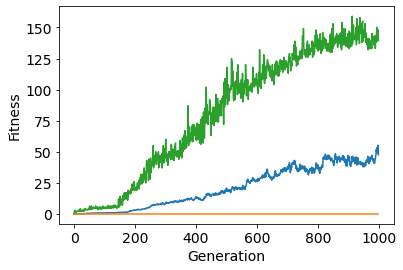

In [18]:
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

bestInd = tools.selBest(pop, 1)[0]
with open('SnakeDefinitive.pkl', 'wb') as file:
    pickle.dump(bestInd, file)
file.close()

#### Following the green line, we see the maximum fitness has a sharp increase around the 175th generation, and continues to increase until around the 995th generation, after which it tapers off. The initial lack of fitness can be explained by a poor initial population of agents attempting to memorise the location(s) of the apples. Eventually however, we see that some agents are able to generalise. Instead of having weights such that an agent will always explore the same tiles expecting food, the weights of the network are such that the agents take into account the inputs from the 8 sensors, and react accordingly.

#### Following the blue line, we see the mean fitness also gradually rises. Due to the relatively large tournament size, the most successful agents produce significantly more offspring. Hence, even when the maximum fitness drops towards the end, we see that the mean continues to increase, showing signs of potentially converging.

#### The yellow line showing the minimum fitness (worst performing agent) is stagnant at y = 0. This can be explained by the large population size and high mutation rate, causing the population to not converge on a local minimum even after 1000 generations.

# SimpleSnake evaluation

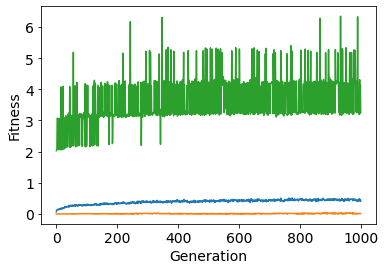

In [46]:
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

bestInd = tools.selBest(pop, 1)[0]
with open('SimpleSnake.pkl', 'wb') as file:
    pickle.dump(bestInd, file)
file.close()

#### Following the green line, we see that the population struggles to produce an agent capable of scoring high. Although the line appears extremely jagged, it must be noted that the graph for SimpleSnake is more zoomed in than that for Snake. The fitness drastically increases (relative to the whole graph) in the first 250 generations, and makes little to no improvement for the next 750 generations. This suggests that the population is stuck at a local minimum, despite the large population and high rate of mutation. Due to the simplicity of both the MLP and the input sensors, the agents simply lack the information and capacity to plan intricate routes through the world.

#### The blue line showing mean fitness hardly increases. We see that it is closer to the minimum fitness (yellow) line than it is to the maximum (green) line, indicating a lack of convergence. We also see that the mean fitness is below 1, which means that most agents were unable to even survive for 256 turns. This means that the agents have been unable to learn to avoid walls/themselves.

#### We once again see the yellow line of minimum fitness stuck at y = 0. The reason for this is the same as was for Snake, that is the large population and high mutation rate, causing a great deal of trail-and-error.

# Best Snake and SimpleSnake Individuals

#### The first tile below loads and runs the best Snake Individual from the population.
#### The second tile below loads and runs the best SimpleSnake Individual from the population.

In [24]:
with open('SnakeDefinitive.pkl', 'rb') as file:
    Ind = pickle.load(file)
file.close()
myNet.setWeightsLinear(Ind)
run_game(display,snake_game, HEADLESS, myNet)

Snake turned into itself!

FINAL score - 127


127

In [45]:
with open('SimpleSnake.pkl', 'rb') as file:
    Ind = pickle.load(file)
file.close()
myNet.setWeightsLinear(Ind)
run_game(display,snake_game, HEADLESS, myNet, True)

Snake hit a wall!

FINAL score - 1


1.04296875

# Final Thoughts

### Key Points:
#### - During implementation, hybrids of Snake and SimpleSnake were also tested - MLP with 4 sensors, MLP_old with 8 sensors. However, the former had too much cognitive capacity and not enough stimulation (input) causing the agents to massively overfit, and the latter had too little cognitive capacity, and so was unable to utilise the stimulation effectively. Snake and SimpleSnake were the best performing of the 4, hence were shown above.

#### - The large discrepancy in performance of Snake and SimpleSnake confirms that depth perception is a major factor in performance, as the game requires the agent not only to react at an immediate level, but also to a certain degree plan ahead, due to the ever decreasing space in the world. Both had food proximity sensors, but we see SimpleSnake struggled to increase its score any higher than 7, as it was not as aware of obstacles (and their proximity) as Snake was.

#### - The stochasticity of evolutionary algorithms played a key part in the code design choices made. The intention was to exploit it by using a large starting population and a high rate of mutation, to prevent the algorithms from getting stuck at local minima. To limit its negative side effects, a large tournament size and a moderate crossover probability was chosen.

#### - Due to the aforementioned randomess, any minor changes made required multiple runs to confirm their effects, creating an inherent lack of certainty during implementation.

### Future Work:
#### - The current implementation of Snake is a 8x2 vision, where each of the 8 sensors provide a tuple for the inverse of the Euclidean distances to food or obstacle in that direction, with the other one being infinite distance. i.e., an apple 3 tiles away would return a tuple [1/3, 0]. This creates opacity where the agent cannot look beyond the nearest blocking object (in this case, the blocking object is the apple). A potential area of experimentation would be to include both food and obstacle distances, such that if an apple is 3 tiles away and an obstacle is right behind it (4 tiles away), the tuple returned could be [1/3, 1/4], enabling the agent to look through objects. 

#### - More inputs could be added, namely the coordinates for the head, and a list of coordinates for the tail. This could allow the agent to be aware of the rest of its body, and so may invent interesting strategies to prevent it from turning into itself.

#### - Naturally, both of these improvements would require a more complex network as well, maybe even a CNN to fully realise its potential. These ideas were not explored due to hardware constraints.